<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/modelacc41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/OCT2022'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/OCT2022/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17779 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4552 4469 4385 4373]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/OCT2022/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2217 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[528 546 540 603]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/OCT2022/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [13]:
num_classes = 4
epochs=20   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [14]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Compile และ Train

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [16]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=epochs,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
556/556 [==============================] - 5725s 10s/step - loss: 1.0145 - accuracy: 0.5775 - val_loss: 1.5839 - val_accuracy: 0.4605
Epoch 2/20
556/556 [==============================] - 1414s 3s/step - loss: 0.4446 - accuracy: 0.8344 - val_loss: 1.8532 - val_accuracy: 0.4790
Epoch 3/20
556/556 [==============================] - 1404s 3s/step - loss: 0.1945 - accuracy: 0.9330 - val_loss: 1.9866 - val_accuracy: 0.5070
Epoch 4/20
556/556 [==============================] - 1407s 3s/step - loss: 0.0733 - accuracy: 0.9756 - val_loss: 3.8884 - val_accuracy: 0.4502
Epoch 5/20
556/556 [==============================] - 1411s 3s/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 4.1841 - val_accuracy: 0.4569
Epoch 6/20
556/556 [==============================] - 1405s 3s/step - loss: 0.0350 - accuracy: 0.9885 - val_loss: 6.5661 - val_accuracy: 0.4321
Epoch 7/20
556/556 [==============================] - 1398s 3s/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 5.0004 - val_accuracy

## ประเมิน

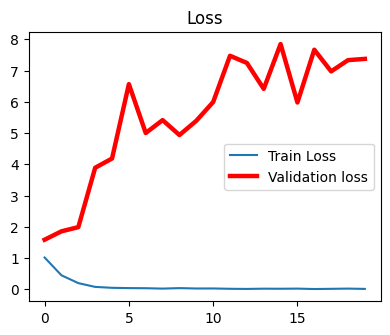

In [17]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

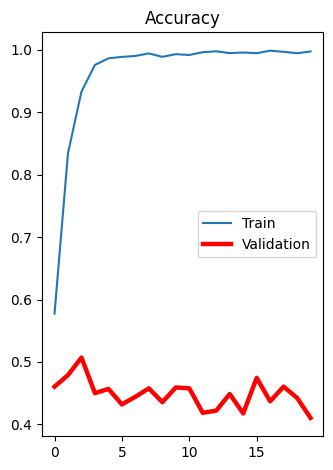

In [18]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.410


### Save Model

In [20]:
modelOCT = '/Model Classification'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/OCT2022/Model Classification/', exist_ok=True)
model.save('/content/drive/MyDrive/OCT2022/Model Classification/modelOCT3.h5')

with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='lastmodelOCT3.h5'
model.save(filepath)
filepath_model = 'lastmodelOCT3.json'
filepath_weights = 'weightsmodel.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weightsmodel.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [21]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Prediction

In [22]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image

In [23]:
train_set.class_indices

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 0s 399ms/step
CSC tf.Tensor(0.47536692, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


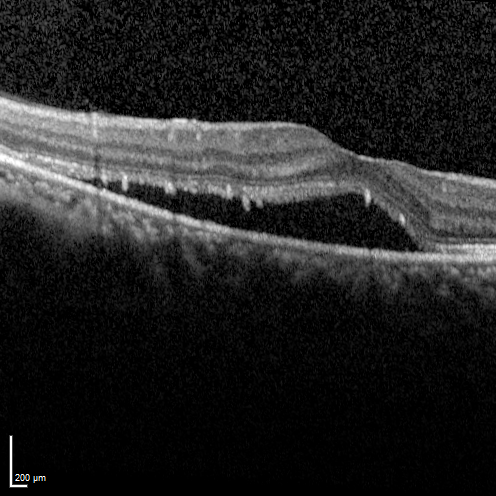

AI CSC มีความมั่นใจ 47.54%.


In [24]:
# CSC
test_path = ('/content/drive/My Drive/OCT2022/test/CSC/IA3870 09-01-17 RE_002011_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 38ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


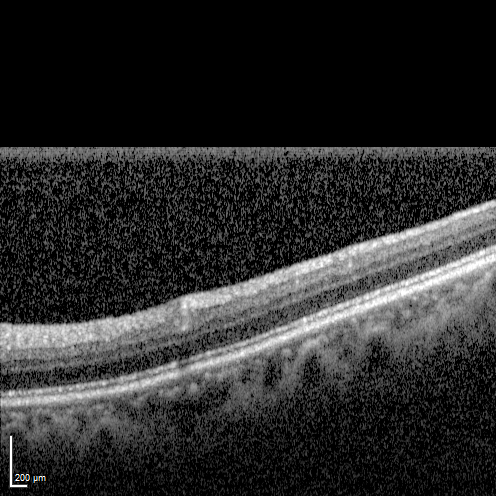

AI Normal มีความมั่นใจ 47.54%.


In [25]:
# Normal
test_path = ('/content/drive/My Drive/OCT2022/test/Normal/ED8056 05-05-17 LE_001024_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) Normal tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.47536686, shape=(), dtype=float32) VKH tf.Tensor(0.1748777, shape=(), dtype=float32)


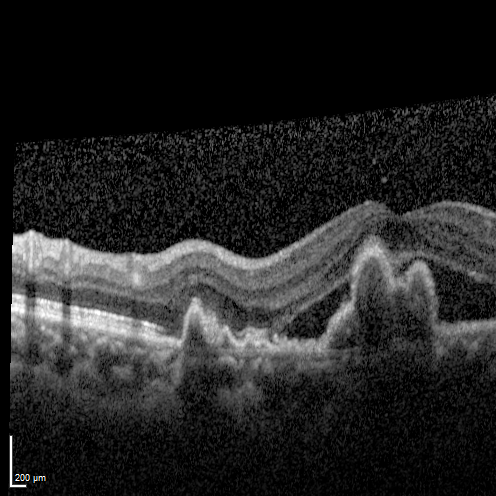

AI PCV มีความมั่นใจ 47.54%.


In [26]:
# PCV
test_path = ('/content/drive/My Drive/OCT2022/test/PCV/BF9378 23-09-18 LE_002011_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
CSC tf.Tensor(0.47536692, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


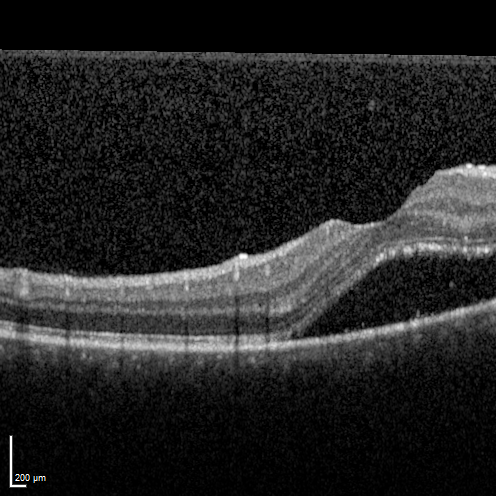

AI CSC มีความมั่นใจ 47.54%.


In [27]:
# VKH
test_path = ('/content/drive/My Drive/lastoct/test/VKH/KN4858 28-02-22 RE_002011_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [28]:
test_set_ = test_set.unbatch()

In [29]:
#test_set.file_paths

In [30]:
import shutil

In [31]:
misclass_path = '/misclassify_model3q '
if not os.path.exists(path+misclass_path):
    os.makedirs(path+misclass_path)

for myFilename in test_set.file_paths:

  tempfn = myFilename.split('/')
  myTrueVal = tempfn[6]
  mySubjID = tempfn[7].rstrip('_cropped.png')

  test_path = (myFilename)
  img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
    )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = predict_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if score[0]==np.max(score):
    eye = "CSC"
  elif score[1]==np.max(score):
    eye = "Normal"
  elif score[2]==np.max(score):
    eye = "PCV"
  elif score[3]==np.max(score):
    eye = "VKH"
  myConfid = np.round(100 * np.max(score),2)
  myPredVal = eye 

  if myTrueVal != myPredVal:
    fn = mySubjID+'__true-'+myTrueVal+'__pred-'+myPredVal+'__'+str(myConfid)+'.png'
    print(fn)
    shutil.copyfile(myFilename, path+misclass_path+'/'+fn)

1/1 [==============================] - 0s 43ms/step
HN2204 10-10-17 LE_001004__true-CSC__pred-Normal__47.54.png
1/1 [==============================] - 0s 42ms/step
KN4858 28-02-22 LE_001022__true-VKH__pred-CSC__47.54.png
1/1 [==============================] - 0s 61ms/step
AV0940 27-04-12 RE_002017__true-PCV__pred-Normal__47.54.png
1/1 [==============================] - 0s 48ms/step
DO2833 05-02-22 LE_002001__true-Normal__pred-CSC__47.54.png
1/1 [==============================] - 0s 42ms/step
HN2204 10-10-17 LE_002024__true-CSC__pred-Normal__47.54.png
1/1 [==============================] - 0s 40ms/step
GE8938 12-13-16 LE_001012__true-CSC__pred-Normal__47.54.png
1/1 [==============================] - 0s 67ms/step
IA2051 25-11-11 RE_000011__true-CSC__pred-Normal__47.54.png
1/1 [==============================] - 0s 65ms/step
CR2619 21-11-19 RE_002011__true-Normal__pred-PCV__47.54.png
1/1 [==============================] - 0s 61ms/step
HI3742 18-07-17 RE_002016__true-CSC__pred-Normal__47.54

In [32]:
myImages = list(test_set_.map(lambda x, y: x))
myLabels = list(test_set_.map(lambda x, y: y))

In [33]:
print(len(myImages),len(myLabels))

2182 2182


In [34]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 39ms/step


In [35]:
print(y_test)
print(len(y_test))

['VKH', 'VKH', 'Normal', 'PCV', 'VKH', 'CSC', 'VKH', 'PCV', 'PCV', 'VKH', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'Normal', 'CSC', 'PCV', 'PCV', 'VKH', 'CSC', 'VKH', 'PCV', 'CSC', 'CSC', 'Normal', 'CSC', 'Normal', 'VKH', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'PCV', 'PCV', 'VKH', 'CSC', 'PCV', 'CSC', 'PCV', 'CSC', 'Normal', 'CSC', 'Normal', 'VKH', 'VKH', 'Normal', 'PCV', 'VKH', 'VKH', 'Normal', 'Normal', 'CSC', 'PCV', 'PCV', 'PCV', 'PCV', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'Normal', 'PCV', 'VKH', 'PCV', 'PCV', 'PCV', 'Normal', 'PCV', 'PCV', 'PCV', 'PCV', 'VKH', 'VKH', 'Normal', 'CSC', 'VKH', 'Normal', 'VKH', 'CSC', 'PCV', 'Normal', 'VKH', 'VKH', 'Normal', 'Normal', 'VKH', 'PCV', 'VKH', 'PCV', 'VKH', 'CSC', 'VKH', 'PCV', 'CSC', 'Normal', 'PCV', 'VKH', 'PCV', 'VKH', 'CSC', 'Normal', 'VKH', 'Normal', 'PCV', 'PCV', 'PCV', 'PCV', 'PCV', 'CSC', 'Normal', 'Normal', 'VKH', 'CSC', 'CSC', 'PCV', 'PCV', 'PCV', 'PCV', 'Normal', 'VKH', 'CSC', 'Normal', 'PCV', 'PCV', 'Normal', 'Normal', 'Normal',

In [36]:
print(y_pred)
print(len(y_pred))

['VKH', 'Normal', 'Normal', 'PCV', 'VKH', 'CSC', 'CSC', 'PCV', 'PCV', 'PCV', 'Normal', 'Normal', 'Normal', 'VKH', 'Normal', 'Normal', 'Normal', 'PCV', 'PCV', 'VKH', 'Normal', 'VKH', 'PCV', 'VKH', 'CSC', 'Normal', 'Normal', 'Normal', 'VKH', 'Normal', 'CSC', 'PCV', 'Normal', 'PCV', 'Normal', 'Normal', 'VKH', 'CSC', 'Normal', 'Normal', 'PCV', 'Normal', 'PCV', 'CSC', 'PCV', 'VKH', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'PCV', 'Normal', 'CSC', 'Normal', 'Normal', 'PCV', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'PCV', 'PCV', 'Normal', 'Normal', 'Normal', 'Normal', 'PCV', 'CSC', 'Normal', 'Normal', 'Normal', 'Normal', 'VKH', 'VKH', 'Normal', 'CSC', 'VKH', 'Normal', 'VKH', 'PCV', 'Normal', 'PCV', 'CSC', 'PCV', 'Normal', 'CSC', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'Normal', 'CSC', 'PCV', 'Normal', 'PCV', 'PCV', 'CSC', 'Normal', 'VKH', 'VKH', 'PCV', 'VKH', 'CSC', 'Normal', 'Normal', 'PCV', 'PCV', 'Normal', 'CSC', 'Normal', 'PCV', 'CSC', 'Normal', 'Normal', 'Normal', 'Normal', 'PCV', 'PCV', 'N

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
confusion_matrix(y_test, y_pred)

array([[148, 265, 123,  16],
       [ 57, 370, 141,   2],
       [ 16, 264, 223,  25],
       [ 71,  95, 144, 222]])

In [39]:
cm = confusion_matrix(y_test, y_pred)

In [40]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [41]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [42]:
cm_df

,CSC,Normal,PCV,VKH
CSC,148,265,123,16
Normal,57,370,141,2
PCV,16,264,223,25
VKH,71,95,144,222


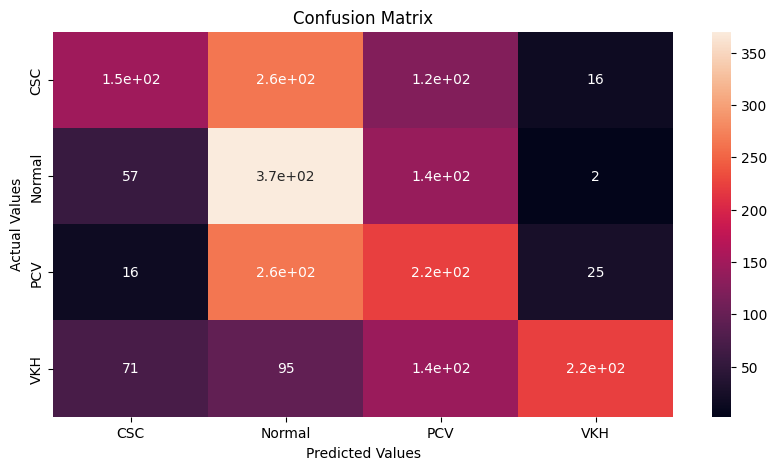

In [43]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [ ]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  786


In [ ]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 36.02%


### หาค่า Accuracy,Recall, Precision, F1-score

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [45]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.441338


In [46]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.441338


In [47]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.515228


In [48]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.441264
